### SENTIMENT ANALYSIS PROJECT..
---

### Metrics Used and How Accuracy is measured.
The metrics used for the purpose of traning the model includes the following:
- Loss: This measures how well the model is performing during training. It is the differentce between the predicted output and the actual or ground truth output expected. In this, an average loss accrosss all items will be used for both training and validation.
        ````Loss = Expected Output - Predicted Output ````

- Accuracy: This meases how well the model is at correctly predicting the target output. Its the ratio of total correctly predicted labels against all labels present. During trainign and validation, average accuracy will be used.
        ```Accuracy = (Total Correct Predicted/ Total Labels)```
    
    
 - Beside above two metrics using during training and validation, In the process of evaluation, other metrics such as Confussion Matrixes (shows correct predictions and incorrect for each classes), f1 score, precision and recall scores will be used for evaluation. These variant methods are used in order to get better results.



 ### How Many data will be Suffient.
 - Since this is a binary classification, dataset around 100k records are enough.  
 - The dataset  will be used from this link:  https://zenodo.org/record/7552959

 - The data contains over 500k records which most of them i.e over 89% are positive labels while the rest are negative. In order to ensure the data is not huge and we can be able to run them on our machines, we will reduces and take only 25% of the postive labels and the rest all for negative labels to have a general total of about 189k records.

In [2]:
!pip install --upgrade torch

In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import random
from tqdm import tqdm

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_warning()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### DATA: https://zenodo.org/record/7552959

In [ ]:
!wget https://zenodo.org/record/7552959/files/prepared_clean_dataset.csv

--2023-08-10 10:16:05--  https://zenodo.org/record/7552959/files/prepared_clean_dataset.csv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123162956 (117M) [text/plain]
Saving to: ‘prepared_clean_dataset.csv’

prepared_clean_data 100%[===================>] 117.46M  3.59MB/s    in 50s     

2023-08-10 10:16:55 (2.37 MB/s) - ‘prepared_clean_dataset.csv’ saved [123162956/123162956]



In [ ]:
import os, re, glob

In [ ]:
os.listdir("./")

['prepared_clean_dataset.csv', '.virtual_documents']

In [ ]:
# read the data
df = pd.read_csv("prepared_clean_dataset.csv")

In [ ]:
# check sample data
df.sample(5)

,Unnamed: 0,Score,Sentiment,words
339196,342462,5.0,1,true mastergreat bandwell worth time classic j...
375084,378468,5.0,1,fun fantastic whimsical memorable characters i...
298926,300751,5.0,1,every episodes makes wonder creative writers m...
509611,514225,4.0,1,released chile mi uacute ltimo round tells sto...
438379,442943,5.0,1,i addicted show can wait second half season wi...


In [ ]:
# drop the unamed column
df = df[["words","Score", "Sentiment"]].reset_index(drop=True)

In [ ]:
# check the shape of the dataset
df.shape

(578419, 3)

In [ ]:
# check NANS
df.isna().sum()

words        25
Score         0
Sentiment     0
dtype: int64

In [ ]:
# drop all nulls
df.dropna(inplace=True)

In [ ]:
# recheck nulls
df.isna().any()

words        False
Score        False
Sentiment    False
dtype: bool

In [ ]:
# check the number of positve and negative sentiments
df.Sentiment.value_counts(normalize=True)

1    0.897011
0    0.102989
Name: Sentiment, dtype: float64

In [ ]:
df['name'] = df['Sentiment'].map({1:"Positive Sentiments", 0:"Negative Sentiments"})

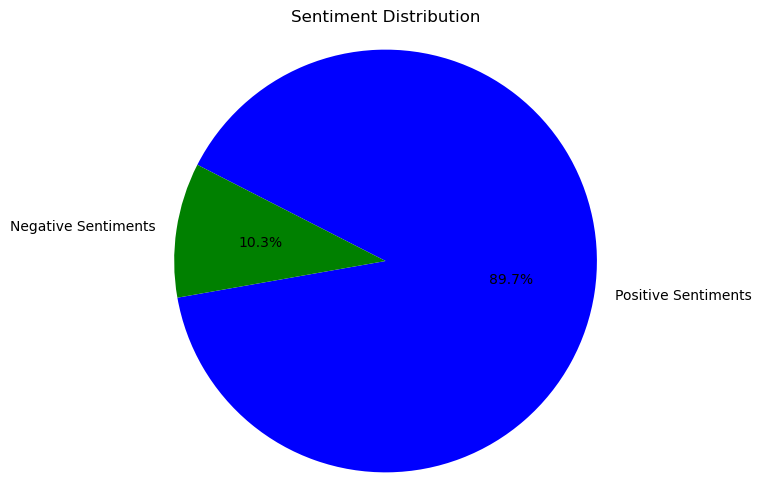

In [ ]:
sentiment_counts = df.name.value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['blue', 'green']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=190)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


In [ ]:
518848*0.2

103769.6

In [ ]:
# store old dataset copy
df_old = df.copy()

In [ ]:
# to avoid overfitting, I will reduce the Postive sentiment by about 60%
# So here, among all the postive labels, I will take only 25% from it while all negative labels will be used/.

# at first am filtering all values for postive and getting 25% then concatinating will all values for negative labels
df = pd.concat([
    df[df['Sentiment'] ==1].sample(frac = 0.25, random_state=2023),
    df[df['Sentiment'] ==0]
], axis=0).sample(frac=1, random_state=23849).reset_index(drop=True)

In [ ]:
# check new data shapes
df.shape

(189274, 4)

In [ ]:
# rename the columns
df.columns = ['text', 'score', "label", "name"]

# recheck
df.head()

,text,score,label,name
0,my husband i love it interesting sometimes com...,5.0,1,Positive Sentiments
1,i avid ghost show watcher i tell show 8217 com...,1.0,0,Negative Sentiments
2,really cute wholesome family fare,5.0,1,Positive Sentiments
3,series twisted funny antics evil demons women ...,5.0,1,Positive Sentiments
4,i read preview notes took second realize play ...,3.0,1,Positive Sentiments


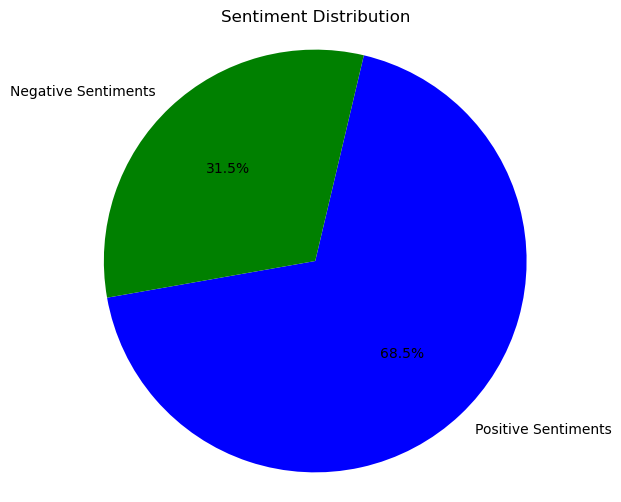

In [ ]:
# repeat the pie chart
sentiment_counts = df.name.value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['blue', 'green']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=190)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


In [ ]:
# check the scores distribution
df.score.value_counts()

5.0    94734
1.0    36237
4.0    24753
2.0    23331
3.0    10219
Name: score, dtype: int64

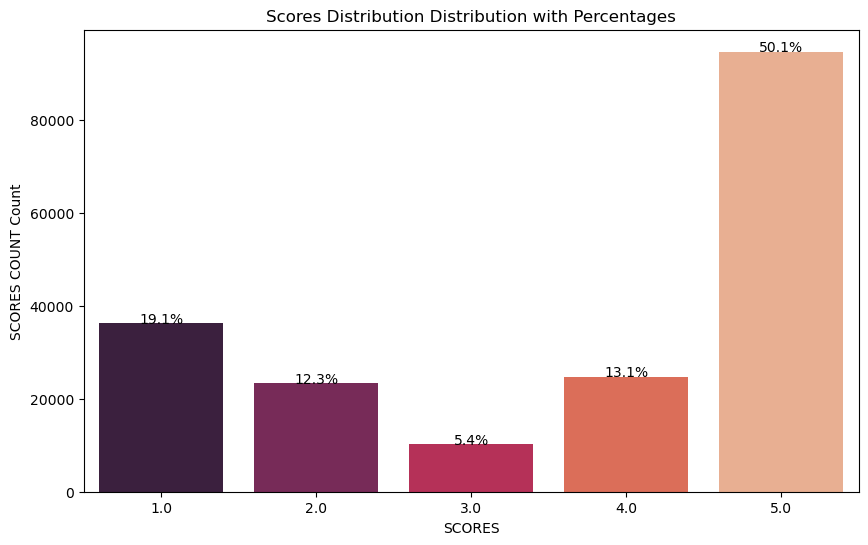

In [ ]:
# plot bar for above
plt.figure(figsize=(10, 6))
# Create the bar plot
ax = sns.countplot(data=df, x='score', palette='rocket')
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            '{:.1f}%'.format((height / total) * 100),
            ha="center")

plt.xlabel('SCORES')
plt.ylabel('SCORES COUNT Count')
plt.title('Scores Distribution Distribution with Percentages')

plt.show()

### Modeling
- Start a simple BERT MODEL

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'

In [ ]:
# encode sample sentence
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
bert_tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_text = df.text[0]

encoding = bert_tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# output of encoder
encoding['input_ids']

tensor([[  101,  2026,  3129,  1045,  2293,  2009,  5875,  2823, 21699,  2467,
         11973,  2057,  2467, 11480,  3422,  2279,  2265,  2186,   102]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


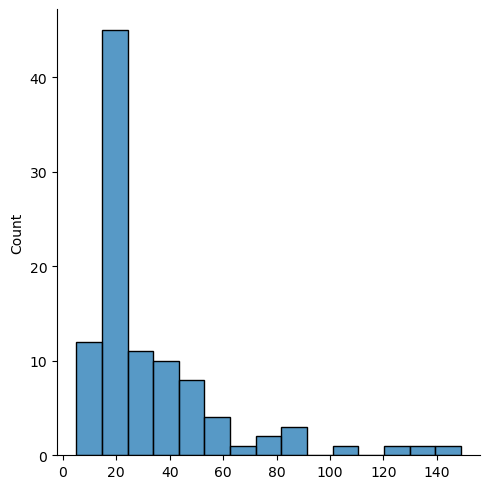

In [ ]:
# check the token length distribution
token_lens = []
for txt in df.sample(100).text:
    token_lens.append(len(bert_tokenizer.encode(txt, max_length=512)))

sns.displot(token_lens)

In [ ]:
# get a sample df for fast training
df_sample = df.sample(20000).reset_index(drop=True)

In [ ]:
# divide data into train (60%), val (20%), test (20%)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_sample.text.values,
    df_sample.label.values,
    test_size=.4,
    random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=.5,
    random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000,), (12000,), (4000,), (4000,), (4000,), (4000,))

### BERT Sentiment Analysis

- BERT(Bidirectional Encoder Representations from Transformers) is a pre-trained language model that can be fine tuned to perform NLP task. Bidirectional means that the model is able to read text from both left-to-right and from right-to-left. This capability helps it to understand context. It can be able to understand over 100 languages as at now.
- Several pretrained are present and are dependent on the size of weights. These are;
    - bert-base-uncased
    - bert-base-cased
    - bert-large-uncased
    - bert-large-cased
    - bert-base-multilingual-uncased
    - bert-base-multilingual-cased
- uncased - All text was converted to lower case before training the model.
- cased - The text used to train the model was not converted to lower case.


#### ::: PAPER {https://arxiv.org/pdf/1810.04805.pdf}


- It normally expect input sentences to be formatted as a list of tokens.
- During training the model replaces each token with a corresponding word embedding vector.
- Each word vector has a length of 768. The max input length for BERT is 512 tokens.

- The input can have the following:
    - input_ids (type: torch tensor)
    - token_type_ids (type: torch tensor)
    - attention_mask (type: torch tensor)
    - labels (type: torch tensor)
    
# 1. input_ids
- The input_ids are the sentence or sentences represented as tokens.There are a few BERT special tokens that one needs to take care of:
    -  [CLS] - Classifier token, value: 101
    -  [SEP] - Separator token, value: 102
     - [PAD] - Padding token, value: 0

-  It  expects every row in the input_ids to have the special tokens included as follows:

# 2. token_type_ids
- Token_type_ids are used when there are two sentences that need to be part of the input.  The token type ids indicate which tokens are part of sentence1 and which are part of sentence2.

# 3. attention_mask
-  The attention mask has the same length as the input_ids.
- It tells the model which tokens in the input_ids are words and which are padding. 1 indicates a word (or special token) and 0 indicates padding.

# 4. labels
- The label (target) for each row in the input_ids.  The labels are integers representing each target class e.g. 1, 2, 3 etc.

---

- The textual dataset will be tokenized by of the model's tokenizer so that we can extract input ids and attention mask

In [ ]:
# set parameter
MAX_LEN = 72
BATCH_SIZE = 32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr_rate = 2e-4
EPOCH = 7
num_classes = 2

In [ ]:
# create dataset
class SentimentDataset(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self,idx):
        sentence = self.text[idx]
        # encode input tex
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
from tensorflow.keras.utils import to_categorical
# create dataloader
train_dataset_bert = SentimentDataset(
    X_train, to_categorical(y_train),
    bert_tokenizer, MAX_LEN
)
train_dataloader_bert = DataLoader(train_dataset_bert,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_bert = SentimentDataset(
    X_val, to_categorical(y_val),
    bert_tokenizer, MAX_LEN
)
val_dataloader_bert = DataLoader(val_dataset_bert,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_bert = SentimentDataset(
    X_test, to_categorical(y_test),
    bert_tokenizer, MAX_LEN
)

In [ ]:
# check the output of dataloader
next(iter(train_dataset_bert))

{'input_ids': tensor([  101,  3294, 22369,  3482,  3104,  2498,  3185,  2245,  2893, 18178,
          2229,  2100,  8301, 18296,  2121,  2143,  3092,  2659,  2659,  2659,
          5166,  1038,  1059,  3538, 29328,  2196,  3727,  2160,  2275,  4076,
          9587, 27102,  2229,  2285,  2839,  2105,  6687,  2160,  4011,  7385,
          2099,  3427,  2034,  2321,  2781,  3241,  2052,  2131,  2488,  2196,
          2059, 21461,  2717,  2156,  5436,  3496,  2052,  2412,  2689,  2123,
          5949,  2769,  4299,  1045,  2071,  2131, 25416,  8630,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 

In [ ]:
# create classifier
class BertSentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# REF:  https://bhashkarkunal.medium.com/pytorch-tutorial-from-basic-to-advance-level-a-numpy-replacement-and-deep-learning-framework-that-a3c8dcf9a9d4
#       https://www.exxactcorp.com/blog/Deep-Learning/advanced-pytorch-lightning-using-torchmetrics-and-lightning-flash

# function to calculate average
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)


        # calculate loss
        optimizer.zero_grad()
        loss = criterion(outputs.float(), targets.float())
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets.argmax(axis=1))
        # update weights
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)

        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs.float(), targets.float())
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets.argmax(axis=1))

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
device

device(type='cuda')

In [ ]:
torch.optim.Adam



torch.optim.adam.Adam

In [ ]:
def run(clf,train_dataloader, val_dataloader, model_name):
    # Load pretrained model
    model = clf
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'{model_name}_best.pth')
    return log

In [ ]:
print("continue")

continue


In [ ]:
BERT_MODEL = BertSentimentClassifier(num_classes)
log = run(BERT_MODEL,train_dataloader_bert,val_dataloader_bert, "BERT")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 125/125 [00:23<00:00,  5.26it/s, accuracy=0.856, epoch=3, loss=0.575]


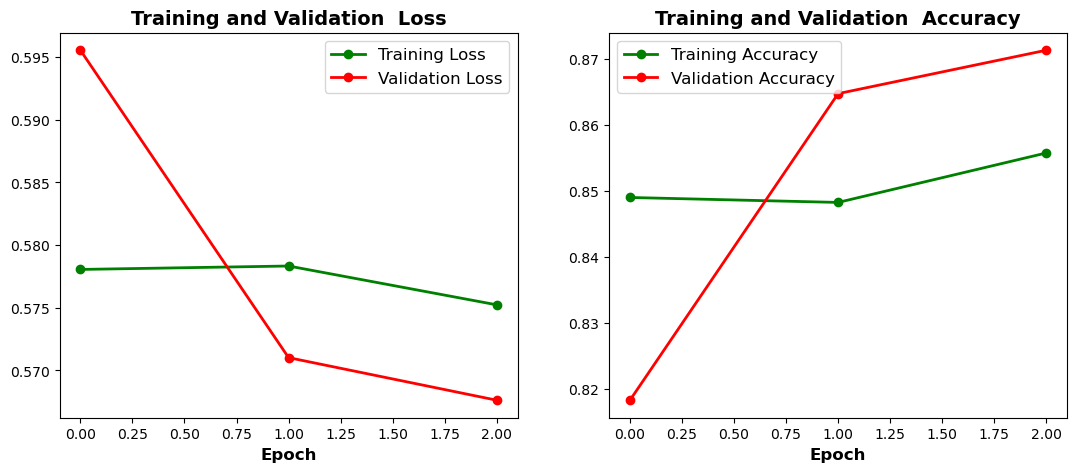

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    ax.plot(val_value,f'go-', label=f'Training {label}', linewidth=2)
    ax.plot(train_value,f'ro-', label=f'Validation {label}', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_title(f'Training and Validation  {label}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)


plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')

In [ ]:
# load weight with best val loss
model_bert = BertSentimentClassifier(num_classes)
model_bert.load_state_dict(torch.load('./BERT_best.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()

    labels = []
    probs =[]
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)

        labels.append(targets.argmax(axis=1).item())
        predictions.append(pred.item())
        probs.append(outputs.tolist()[0])
    return labels, predictions, probs

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# predict test dataset
labels_bert, preds_bert, probs_bert = test_fn(test_dataset_bert, model_bert, device)

100%|██████████| 4000/4000 [02:08<00:00, 31.17it/s]


In [ ]:
np.array(probs_bert).max(1)

array([0.99994802, 0.99992299, 0.99902415, ..., 0.999933  , 0.99991202,
       0.99995542])

In [ ]:
print(f'Label\t\t:{labels_bert[:10]}')
print(f'Prediction\t:{preds_bert[:10]}')
print(f"Probs \t {np.array(probs_bert).max(1)[:10]}")

Label		:[1, 1, 0, 1, 1, 0, 1, 0, 1, 1]
Prediction	:[1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
Probs 	 [0.99994802 0.99992299 0.99902415 0.99994576 0.99994326 0.9998982
 0.99994874 0.99317014 0.99994838 0.99995708]


In [ ]:
LABELS = ["NEGATIVE", "POSITIVE"]

Accuracy Score is  0.849000
F1 Score is  0.892066
Recall Score is  0.906977
Precision Score is  0.8776371308016878


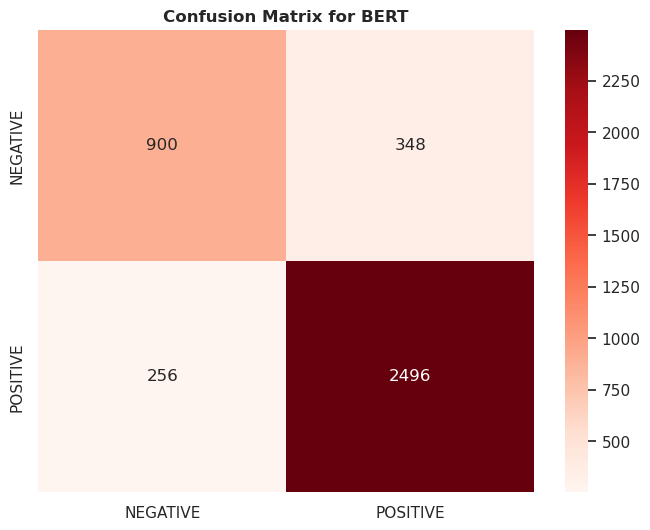

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import scikitplot as skplt
def print_model_perfomance(labels, preds, model_name):
    print("Accuracy Score is  {:4f}".format(accuracy_score(labels, preds)))
    print("F1 Score is  {:4f}".format(f1_score(labels, preds)))
    print("Recall Score is  {:4f}".format(recall_score(labels, preds)))
    print("Precision Score is  {:4}".format(precision_score(labels, preds)))
    # visualize predictions
    sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
    plt.title(f"Confusion Matrix for {model_name}", fontweight="bold")
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=LABELS,yticklabels=LABELS);


print_model_perfomance(labels_bert, preds_bert, "BERT")

In [ ]:
# get classification reports
preds1 = pd.Series(preds_bert).map({1:"Positive", 0:"Negative"})
labels1 = pd.Series(labels_bert).map({1:"Positive", 0:"Negative"})


In [ ]:
print(classification_report(labels1,preds1))

              precision    recall  f1-score   support

    Negative       0.78      0.72      0.75      1248
    Positive       0.88      0.91      0.89      2752

    accuracy                           0.85      4000
   macro avg       0.83      0.81      0.82      4000
weighted avg       0.85      0.85      0.85      4000



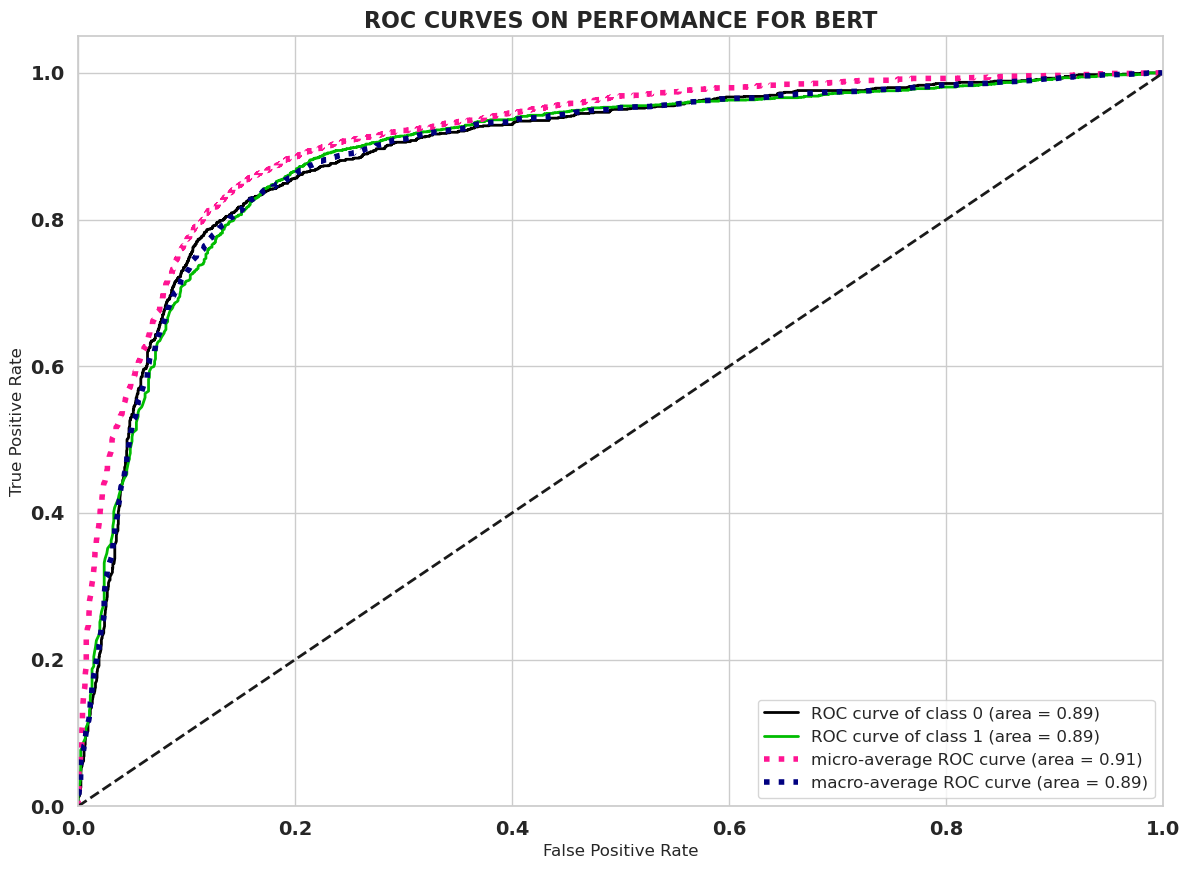

In [ ]:
# we will plot the ROC CURVES
def plot_roc_curves(actual_labels, preds_proba, model_name):
    skplt.metrics.plot_roc(np.array(actual_labels), preds_proba, figsize=(14, 10))
    plt.title(f"ROC CURVES ON PERFOMANCE FOR {model_name}",fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.show()

plot_roc_curves(labels_bert, probs_bert, "BERT")

### ROBERTA Model.

- It is build based on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
- The data and format of training is similar to bert

In [ ]:
# First prepare the tokenizer
ROBERTA_PRETRAINED_NAME ='roberta-base'
roberta_tokenizer = transformers.RobertaTokenizerFast.from_pretrained('roberta-base')
# config for the model
model_config = transformers.RobertaConfig.from_pretrained(ROBERTA_PRETRAINED_NAME)
model_config.output_hidden_states = True



# we then prepare the same dataset as we did for BERT.. But in this case we use ROBERTA TOKENIZER

# create dataloader
train_dataset_roberta = SentimentDataset(
    X_train, to_categorical(y_train),
    roberta_tokenizer, MAX_LEN
)
train_dataloader_roberta = DataLoader(train_dataset_roberta,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_roberta = SentimentDataset(
    X_val, to_categorical(y_val),
    roberta_tokenizer, MAX_LEN
)
val_dataloader_roberta = DataLoader(val_dataset_roberta,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_roberta = SentimentDataset(
    X_test, to_categorical(y_test),
    roberta_tokenizer, MAX_LEN
)


In [ ]:
len(y_val), X_val.shape, y_train.shape, X_train.shape, MAX_LEN

(4000, (4000,), (12000,), (12000,), 100)

- Lets now Define ROberta Model..

In [ ]:
class RobertaSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(RobertaSentimentClassifier, self).__init__()
        self.roberta = transformers.RobertaModel.from_pretrained(ROBERTA_PRETRAINED_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()



In [ ]:
# torch.cuda.empty_cache()
ROBERTA_MODEL = RobertaSentimentClassifier(num_classes)
log2 = run(ROBERTA_MODEL, train_dataloader_roberta, val_dataloader_roberta, "ROBERTA")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [00:22<

In [ ]:
# ROBERTA_MODEL.to(device)

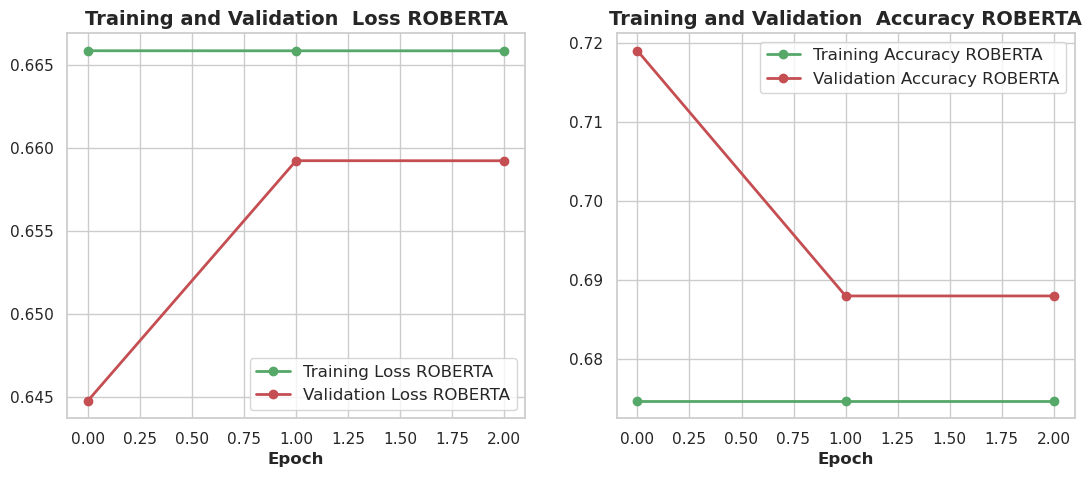

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
plot_log(axs[0],log2.train_loss,log2.val_loss,'Loss ROBERTA')
plot_log(axs[1],log2.train_accuracy,log2.val_accuracy,'Accuracy ROBERTA')

In [ ]:
# load the wiehgts for roberta
model_roberta = RobertaSentimentClassifier(num_classes)
model_roberta.load_state_dict(torch.load('./ROBERTA_best.pth'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
# lets get the predictions
labels_roberta, preds_roberta, probs_roberta = test_fn(test_dataset_roberta, model_roberta, device)

100%|██████████| 4000/4000 [02:04<00:00, 32.17it/s]


Accuracy Score is  0.688000
F1 Score is  0.815166
Recall Score is  1.000000
Precision Score is  0.688


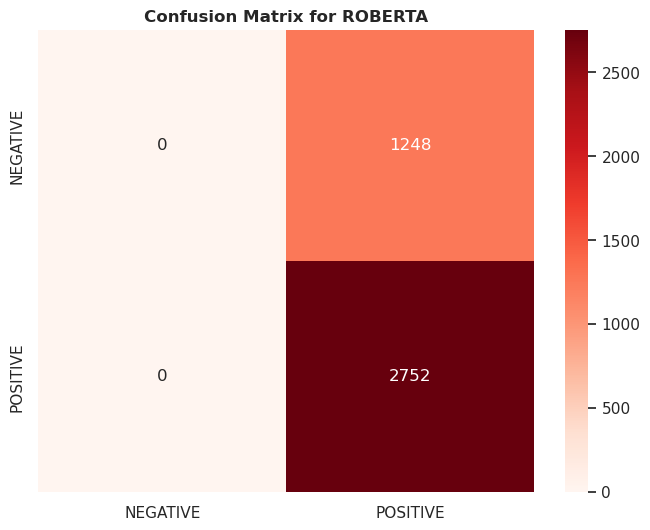

In [ ]:
# print the perfomance
print_model_perfomance(labels_roberta, preds_roberta, "ROBERTA")

In [ ]:
# print classification report
print(classification_report(
    pd.Series(preds_roberta).map({1:"Positive", 0:"Negative"}),
    pd.Series(labels_roberta).map({1:"Positive", 0:"Negative"}))
     )

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
    Positive       1.00      0.69      0.82      4000

    accuracy                           0.69      4000
   macro avg       0.50      0.34      0.41      4000
weighted avg       1.00      0.69      0.82      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


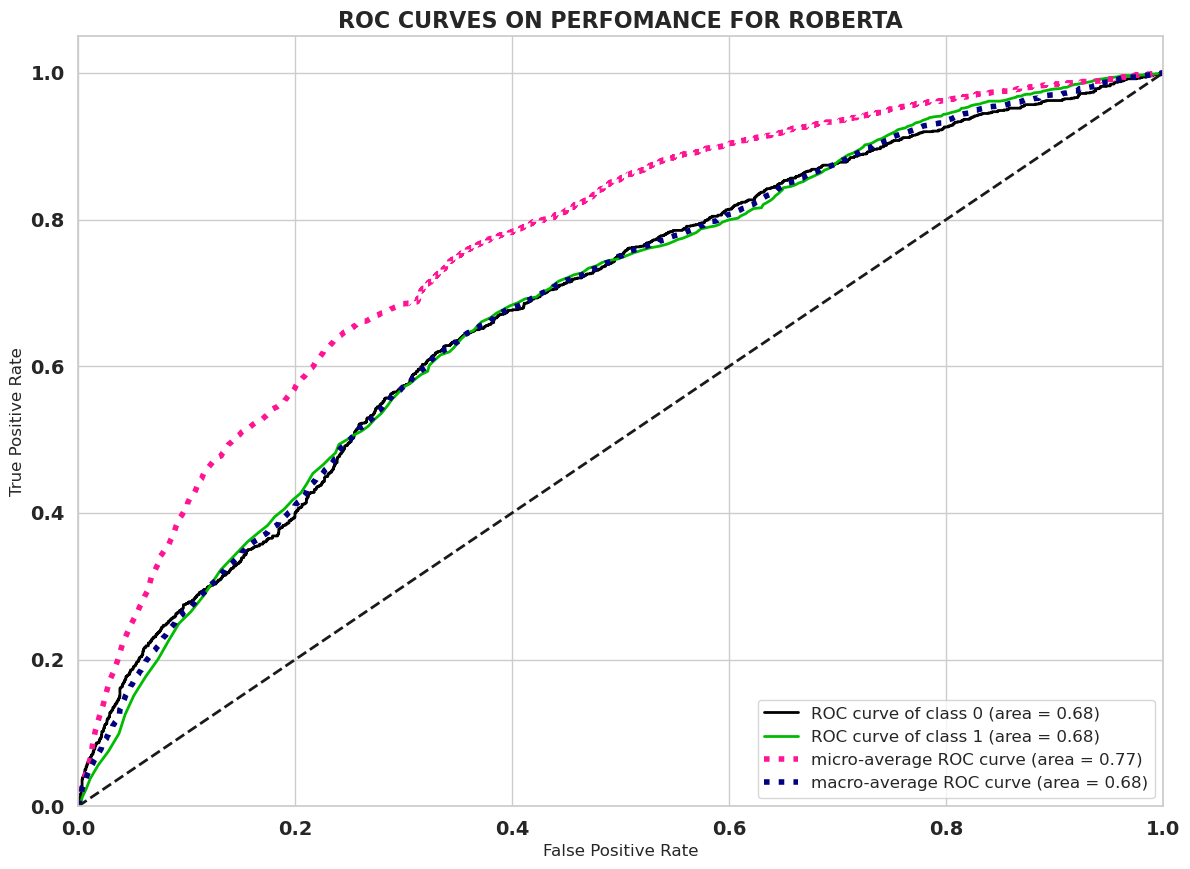

In [ ]:
plot_roc_curves(labels_roberta, probs_roberta, "ROBERTA")

### XLNET model

- XLnet is an extension of the Transformer-XL model pre-trained using an autoregressive method to learn bidirectional contexts by maximizing the expected likelihood over all permutations of the input sequence factorization order.
- We randomly remove some tokens in input data and we try to predict these removed tokens. mt is a mask that is 1 when a token is removed 1 elsewhere. Pretraining the model with this task helps learn patterns data and the model performs well in downstream tasks using the learned parameters.


- The inputs are same as that of BERT except its output is jsut the predictions only, here is the implimentation.

---

In [ ]:
# we define all the data required for it first
# First prepare the tokenizer
XLNET_PRETRAINED_NAME ='xlnet-base-cased'
xlnet_tokenizer = transformers.AutoTokenizer.from_pretrained(XLNET_PRETRAINED_NAME)

# THe preparation of the dataset is same for all since they are transfomers of same origin
train_dataset_xlnet = SentimentDataset(
    X_train, to_categorical(y_train),
    xlnet_tokenizer, MAX_LEN
)
train_dataloader_xlnet = DataLoader(train_dataset_xlnet,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_xlnet = SentimentDataset(
    X_val, to_categorical(y_val),
    xlnet_tokenizer, MAX_LEN
)
val_dataloader_xlnet = DataLoader(val_dataset_xlnet,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_xlnet = SentimentDataset(
    X_test, to_categorical(y_test),
    roberta_tokenizer, MAX_LEN
)


In [ ]:
# define XLNET model
class XLNetSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(XLNetSentimentClassifier, self).__init__()
        #self.xlnet = transformers.XLNetModel.from_pretrained(XLNET_PRETRAINED_NAME)
        self.xlnet = transformers.AutoModelForSequenceClassification.from_pretrained(XLNET_PRETRAINED_NAME, num_labels=n_classes)
        #self.drop = nn.Dropout(p=0.3)
        #self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.xlnet(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        #print(len(pooled_output)
        out_re = pooled_output[0]
        #output = self.drop(pooled_output)
        #output = self.out(output)
        return self.softmax(out_re)


In [ ]:
# train xlnet model
torch.cuda.empty_cache()
gc.collect()
XLNET_MODEL = XLNetSentimentClassifier(num_classes)
log_xlnet = run(XLNET_MODEL, train_dataloader_xlnet, val_dataloader_xlnet, "XLNET_MODEL")

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
print()

In [ ]:
# plot the results of XLNET
fig, axs = plt.subplots(1,2,figsize=(13,5))
plot_log(axs[0],log_xlnet.train_loss,log_xlnet.val_loss,'Loss XLNET')
plot_log(axs[1],log_xlnet.train_accuracy,log_xlnet.val_accuracy,'Accuracy XLNET')

In [ ]:
# load the models weights for xlnet
model_xlnet = XLNetSentimentClassifier(num_classes)
model_xlnet.load_state_dict(torch.load('./XLNET_MODEL_best.pth'))

In [ ]:
# lets get the perfomance for XLNET model
labels_xlnet, preds_xlnet, probs_xlnet = test_fn(test_dataset_xlnet, model_xlnet, device)

In [ ]:

print_model_perfomance(labels_xlnet, preds_xlnet, "XLNET MODEL")

In [ ]:
print(classification_report(
    pd.Series(preds_xlnet).map({1:"Positive", 0:"Negative"}),
    pd.Series(labels_xlnet).map({1:"Positive", 0:"Negative"}))
     )

In [ ]:
# plot ROC curve for the same
plot_roc_curves(labels_xlnet, probs_xlnet, "XLNET MODEL")